In [76]:
#!!!!注意，請先執行這個區塊載入 Google 雲端硬碟再執行底下的程式
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Ch11 自然語言處理實戰演練 (一)：資料預處理、建立詞向量空間

#### 載入相關模組

In [77]:
import nltk    # Natural Language Toolkit  自然語言處理工具包                 大部分預處理都用這個套件來做
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('gutenberg')  # 某電子書的一小部分拿來做為語料庫，該語料庫已經被包在nltk模組中
nltk.download('punkt')
nltk.download('stopwords')

import numpy as np

import string

import gensim       #提供豐富的語料庫、資料預處理功能以及建立向量功能
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure
%matplotlib inline

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 11.1.1 斷句與斷字（tokenization）

In [78]:
from nltk.corpus import gutenberg

In [79]:
len(gutenberg.fileids())

18

In [80]:
gutenberg.fileids()    #可看到包含在裡面的所有文字檔檔名

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [81]:
len(gutenberg.words())     #該語錄庫所有的單字:為262萬個

2621613

#####斷句處理

In [82]:
gberg_sent_tokens = sent_tokenize(gutenberg.raw())       #sent_tokenize()會將這18個文字檔每個句子分開

In [83]:
gberg_sent_tokens[0]

'[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.'

In [84]:
gberg_sent_tokens[1]

"She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period."

#####斷字處理

In [85]:
word_tokenize(gberg_sent_tokens[1])     #利用word_tokenize()做斷字處理，把每一個單字分開

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'s",
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

In [86]:
word_tokenize(gberg_sent_tokens[1])[14]    #第一句中第14個字

'father'

#####用 sents() method 一次做完斷句、斷字

In [87]:
# a convenient method that handles newlines, as well as tokenizing sentences and words in one shot
gberg_sents = gutenberg.sents()

原句: [Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I

In [88]:
gberg_sents[0:3]   #利用 .sents() 可斷成不同的句子

[['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']'],
 ['VOLUME', 'I'],
 ['CHAPTER', 'I']]

In [89]:
gberg_sents[4][14]

'father'

#### 11.1.2 將大寫字母轉成小寫 (以艾瑪第 1 句為例)

##### 原本索引 4 這句的內容

In [90]:
gberg_sents[4]

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

##### 將索引 4 這句轉成小寫

In [91]:
[w.lower() for w in gberg_sents[4]]

['she',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

#### 11.1.3 移除停用字與標點符號 (以艾瑪第 1 句為例)

In [92]:
stpwrds = stopwords.words('english') + list(string.punctuation)   #將英語停用字串列stopwords.words('english')與string函式庫的標點符號串列string.punctuation結合一起

In [93]:
stpwrds  #包含很多無特殊涵義的常用字

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

原本:

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.

In [94]:
[w.lower() for w in gberg_sents[4] if w.lower() not in stpwrds]   #利用串列生成來刪除出現在stpwrds中的字

['youngest',
 'two',
 'daughters',
 'affectionate',
 'indulgent',
 'father',
 'consequence',
 'sister',
 'marriage',
 'mistress',
 'house',
 'early',
 'period']

#### 11.1.4 字根提取 (stemming) (以艾瑪第 1 句為例)

In [95]:
stemmer = PorterStemmer()   #利用nltk的Porter演算法

In [96]:
[stemmer.stem(w.lower()) for w in gberg_sents[4]   #提取各單字的字根   
 if w.lower() not in stpwrds] 

['youngest',
 'two',
 'daughter',
 'affection',
 'indulg',
 'father',
 'consequ',
 'sister',
 'marriag',
 'mistress',
 'hous',
 'earli',
 'period']

eg. daughters -> daughter 、house -> hous(為了將house、housing視為相同) 、early -> earli(為了將early-earlier-earlist)一視同仁 

#### 11.1.5 找出 n-gram 詞彙並串成單一詞彙

#####將語料庫中的 2-gram (bigram, 雙字母組)  詞彙檢測出來

2-gram:一個單字意思卻用兩個單字寫  eg. New York

目標要將New York從分開的2-gram轉換成New_York 這樣的單一詞彙(中間用"_"串起來)

# Step 1: 先整理出語料庫中有哪些2-gram詞彙

In [97]:
phrases = Phrases(gberg_sents) 

Phrases()可從語言庫中抓取所有曾相繼出現的單字組合，並一一比較該單字組合的出現頻率與各自出現的頻率，此步驟稱為「2-gram 詞彙配對(bigram collocation)」，最終會傳回一個2-gram詞彙的特殊物件。

# Step 2: 再各自用"_"串起來

In [98]:
bigram = Phraser(phrases)    #Phraser()再將phrases()做整理，建立更高效的物件使用

In [99]:
bigram.phrasegrams     #幫我們依照分數，將常出現的字合在一起

{'two_daughters': 11.966813731181547,
 'her_sister': 17.7960829227865,
 "'_s": 31.066242737744524,
 'very_early': 11.01214147275924,
 'Her_mother': 13.529425062715127,
 'long_ago': 63.22343628984789,
 'more_than': 29.023584433996874,
 'had_been': 22.306024648925288,
 'an_excellent': 39.063874851750626,
 'Miss_Taylor': 453.75918026073305,
 'very_fond': 24.134280468850747,
 'passed_away': 12.35053642325912,
 'too_much': 31.376002029426687,
 'did_not': 11.72841621714281,
 'any_means': 14.096964108090186,
 'wedding_-': 17.4695197740113,
 'Her_father': 13.129571562488772,
 'after_dinner': 21.528548116881705,
 'self_-': 47.79018053120332,
 'sixteen_years': 107.0461671612265,
 'five_years': 40.128755673408115,
 'years_old': 54.735425236061104,
 'seven_years': 52.59411150244507,
 'each_other': 79.4168405322873,
 'a_mile': 12.783091600264584,
 'must_be': 10.229989650632808,
 'difference_between': 220.52537305244678,
 'could_not': 10.870983286982371,
 'having_been': 11.53801833156938,
 'miles_of

##### 測試看看 bigram 物件能否運作

In [100]:
test_sentence = "Miss Taylor has two daughters".split()

In [101]:
test_sentence

['Miss', 'Taylor', 'has', 'two', 'daughters']

In [102]:
bigram[test_sentence]

['Miss_Taylor', 'has', 'two_daughters']

#### 11.1.6 處理整個古騰堡語料庫

#### 去大寫、刪除標點符號

In [103]:
lower_sents = []
for s in gberg_sents:   #處理整個語料庫
    lower_sents.append([w.lower() for w in s if w.lower()   #大寫轉小寫
                        not in list(string.punctuation)])    #去除標點符號

#### 建立 2-gram 詞彙物件

In [104]:
lower_bigram = Phraser(Phrases(lower_sents))  

In [105]:
lower_bigram.phrasegrams # 全小寫的 2-gram

{'two_daughters': 11.080802900992637,
 'her_sister': 16.93971298099339,
 'very_early': 10.516998773665177,
 'her_mother': 10.70812618607742,
 'long_ago': 59.22644201533601,
 'more_than': 28.529926612065935,
 'had_been': 21.583193129694834,
 'an_excellent': 37.41859680854167,
 'sixteen_years': 131.42913000977518,
 'miss_taylor': 420.4340982546865,
 'mr_woodhouse': 104.19907841850323,
 'very_fond': 24.185726346489627,
 'passed_away': 11.751473221742694,
 'too_much': 30.363090173835406,
 'did_not': 10.846196223896685,
 'any_means': 14.294148100212627,
 'after_dinner': 18.60737125272944,
 'mr_weston': 91.63290824201266,
 'five_years': 37.66428596665674,
 'years_old': 48.59909444619029,
 'seven_years': 50.3345604292756,
 'each_other': 71.31277029783762,
 'well_informed': 14.185028016786626,
 'a_mile': 11.700110753652233,
 'difference_between': 207.86784241868986,
 'mrs_weston': 180.6778969011602,
 'could_not': 10.213333164207082,
 'having_been': 10.723750443105281,
 'sixteen_miles': 105.040

#####進一步過濾 2-gram 語法

In [106]:
lower_bigram = Phraser(Phrases(lower_sents, 
                min_count=32, threshold=64))    #min_count最小出現次數設為32，threshold最小分數設為64
lower_bigram.phrasegrams

{'miss_taylor': 156.44059469941823,
 'mr_woodhouse': 82.04651843976633,
 'mr_weston': 75.87438262077481,
 'mrs_weston': 160.6848509325892,
 'great_deal': 93.36368125424357,
 'mr_knightley': 161.74131790625913,
 'miss_woodhouse': 229.03802722366902,
 'years_ago': 74.31594785893046,
 'mr_elton': 121.3990121932397,
 'dare_say': 89.94000515807346,
 'frank_churchill': 1316.4456593286038,
 'miss_bates': 276.3958829169252,
 'drawing_room': 84.91494947493561,
 'mrs_goddard': 143.57843432545658,
 'miss_smith': 73.03442128232508,
 'few_minutes': 204.16834974753786,
 'john_knightley': 83.03755747111268,
 'don_t': 250.30957446808512,
 'good_natured': 88.69936184891343,
 'few_moments': 107.77584531675087,
 'thousand_pounds': 166.51834523092802,
 'o_clock': 89.14789088153574,
 'jane_fairfax': 654.556591758761,
 'miss_fairfax': 196.19987447261062,
 'ma_am': 157.25846601094193,
 'mrs_elton': 93.08931456265867,
 'forty_years': 90.60220877269607,
 'cut_off': 129.60290535032792,
 'ten_thousand': 84.00099

##### 最終處理：將語料庫的所有 2-gram 串成單一詞彙

In [107]:
clean_sents = []
for s in lower_sents:    #lower_sents已經是已轉小寫、已移除標點符號的語料庫了
    clean_sents.append(lower_bigram[s])

In [108]:
clean_sents[6]   #整理完成的結果

['sixteen',
 'years',
 'had',
 'miss_taylor',
 'been',
 'in',
 'mr_woodhouse',
 's',
 'family',
 'less',
 'as',
 'a',
 'governess',
 'than',
 'a',
 'friend',
 'very',
 'fond',
 'of',
 'both',
 'daughters',
 'but',
 'particularly',
 'of',
 'emma']

#### 11.2 用 word2vec (word to vector) 建立詞向量空間

#### 11.2.3 使用 word2vec

#### 建立詞向量空間模型物件

In [109]:
model = Word2Vec(sentences=clean_sents, vector_size=64,     
                  sg=1, window=10, epochs=5,
                  min_count=10, workers=4)


Word2Vec()參數說明

sentences = 二層串列的語意資料庫，傳入先前整理好的資料，串列第一層是句子，第二層是token(每個單字)

size = 指定word2vec生成的詞向量空間維度，表示想用幾個值來表示一個token

sg = 1  代表套用SG(skip-gram)架構:<用目標字來預測脈絡字，適合小型資料集>，設為0則表示採用CBOW(continuous bag of words)架構:<用脈絡字來預測目標字，較快，對常見單字較有利>

window = 10 代表前後共20個脈絡字，若用CBOW則建議5

iter = 代表走訪語料庫單字的次數，類似epoch(訓練週期)

min_count = 代表單字至少要在語料庫中出現一定的次數，才會被嵌入詞向量空間

workers = 投入訓練的CPU核心數量。eg.若CPU為8核心，那最多只能開8個執行緒來平行處理




In [110]:
#model.save('/content/drive/MyDrive/NLP/Ch11/model_test.w2v')  #儲存先前訓練好的w2v模型

In [111]:
#將訓練好的w2v模型載入 
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/NLP/Ch11/model_test.w2v')  

### 查看模型 (詞向量空間) 的內容

In [112]:
len(model.wv.key_to_index)

10329

In [113]:
model.wv['dog']   #語料庫中的dog這個字，在64維向量空間位置

array([ 0.38401067,  0.01232518, -0.37594706, -0.00112308,  0.38663676,
        0.01287549,  0.398965  ,  0.0096426 , -0.10419296, -0.02877572,
        0.3207022 ,  0.27838793,  0.62772304,  0.34408906,  0.23356602,
        0.24557391,  0.3398472 ,  0.07168821, -0.18941355, -0.10122284,
       -0.35172758,  0.4038952 , -0.12179806,  0.096336  ,  0.00641343,
        0.02332107,  0.7743452 ,  0.03591069, -0.20103034, -0.1688079 ,
       -0.01331445, -0.29832968,  0.08522387, -0.02750671,  0.32494134,
       -0.14266558, -0.4192913 , -0.09291836, -0.23813559,  0.38258648,
        0.11036541,  0.005807  , -0.16745028,  0.34308755, -0.20224966,
       -0.77683043,  0.05146591, -0.5883941 , -0.0718769 , -0.18120563,
        0.00358319, -0.29351747,  0.153776  ,  0.48048878,  0.22479494,
        0.5465321 ,  0.29695514,  0.00986911, -0.2450937 , -0.19344331,
        0.3541134 ,  0.3426432 , -0.10496043,  0.00543602], dtype=float32)

#### 評估生成的詞向量空間

可使用most_similar()對生成的詞向量空間做評估，找出意義上相近的字

In [114]:
model.wv.most_similar('father', topn=3)

[('mother', 0.8257375359535217),
 ('brother', 0.7275018692016602),
 ('sister', 0.7177824378013611)]

In [115]:
model.wv.most_similar('dog', topn=3)

[('puppy', 0.7834004759788513),
 ('cage', 0.7651870846748352),
 ('brahmin', 0.7646074295043945)]

In [116]:
model.wv.most_similar('eat', topn=3)

[('drink', 0.8292896747589111),
 ('bread', 0.8157558441162109),
 ('meat', 0.763256311416626)]

In [117]:
model.wv.most_similar('day', topn=3)

[('morning', 0.7578362822532654),
 ('night', 0.7324315905570984),
 ('week', 0.7262507081031799)]

可使用doesnt_match()分析句子中，哪個字最與眾不同

In [118]:
model.wv.doesnt_match("mother father sister brother dog".split())

'dog'

可使用similarity()看詞之間的相似性分數

In [119]:
model.wv.similarity('father', 'mother')

0.8257376

對詞向量進行加減，看會得出哪些相關的詞

In [120]:
model.wv.most_similar(positive=['father', 'woman'], negative=['man'])   #father + woman - man = mother

[('mother', 0.7650133967399597),
 ('husband', 0.7556627988815308),
 ('sister', 0.7482179999351501),
 ('daughter', 0.7390403151512146),
 ('wife', 0.7284981608390808),
 ('sarah', 0.6856438517570496),
 ('daughters', 0.6652647256851196),
 ('conceived', 0.6637862920761108),
 ('rebekah', 0.6580977439880371),
 ('dearly', 0.6398963928222656)]

In [121]:
model.wv.most_similar(positive=['husband', 'woman'], negative=['man']) 

[('wife', 0.707526445388794),
 ('sister', 0.6973984837532043),
 ('maid', 0.6911259293556213),
 ('daughter', 0.6799546480178833),
 ('mother', 0.6583081483840942),
 ('child', 0.6433471441268921),
 ('conceived', 0.6391384601593018),
 ('harlot', 0.6089694499969482),
 ('daughters', 0.6069823503494263),
 ('marriage', 0.5894293785095215)]

####11.2.4 將詞向量空間描繪出來

利用降維(Dimension Reduction)，將64維降至2~3維

這邊利用降維方法t-SNE(t隨機鄰近嵌入法,t-distributed stohastic neighbor embedding)

In [122]:
tsne = TSNE(n_components=2, n_iter=1000)   #將維度從64維降成2維，走訪次數為100次

In [132]:
vectors = model.wv.vectors

In [133]:
X_2d = tsne.fit_transform(vectors)

In [135]:
keys = list(model.wv.key_to_index.keys())
coords_df = pd.DataFrame(X_2d, columns=['x', 'y'])  #再用Pandas的DataFrame格式儲存二維資料
coords_df['token'] = keys   #將單字丟入keys欄位中

In [145]:
#存檔語法
#coords_df.to_csv('/content/drive/MyDrive/NLP/Ch11/test_final.csv', index=False)

In [136]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 執行以下區塊可直接取用本書轉換好的檔案, !!!!注意，執行此區塊前，請先執行上面這個區塊載入 Google 雲端硬碟!!!

In [ ]:
#coords_df = pd.read_csv('/content/drive/MyDrive/NLP/Ch11/ch11-clean_gutenberg_tsne.csv')

##### 檢視 2 維的詞向量內容

In [137]:
coords_df.head()

,x,y,token
0,-23.431974,-46.242371,emma
1,-23.432423,-46.207527,by
2,-23.080214,-46.400352,jane
3,-23.495754,-45.676807,volume
4,-24.918303,-45.070911,i


#### 將 2 維的詞向量繪成散布圖

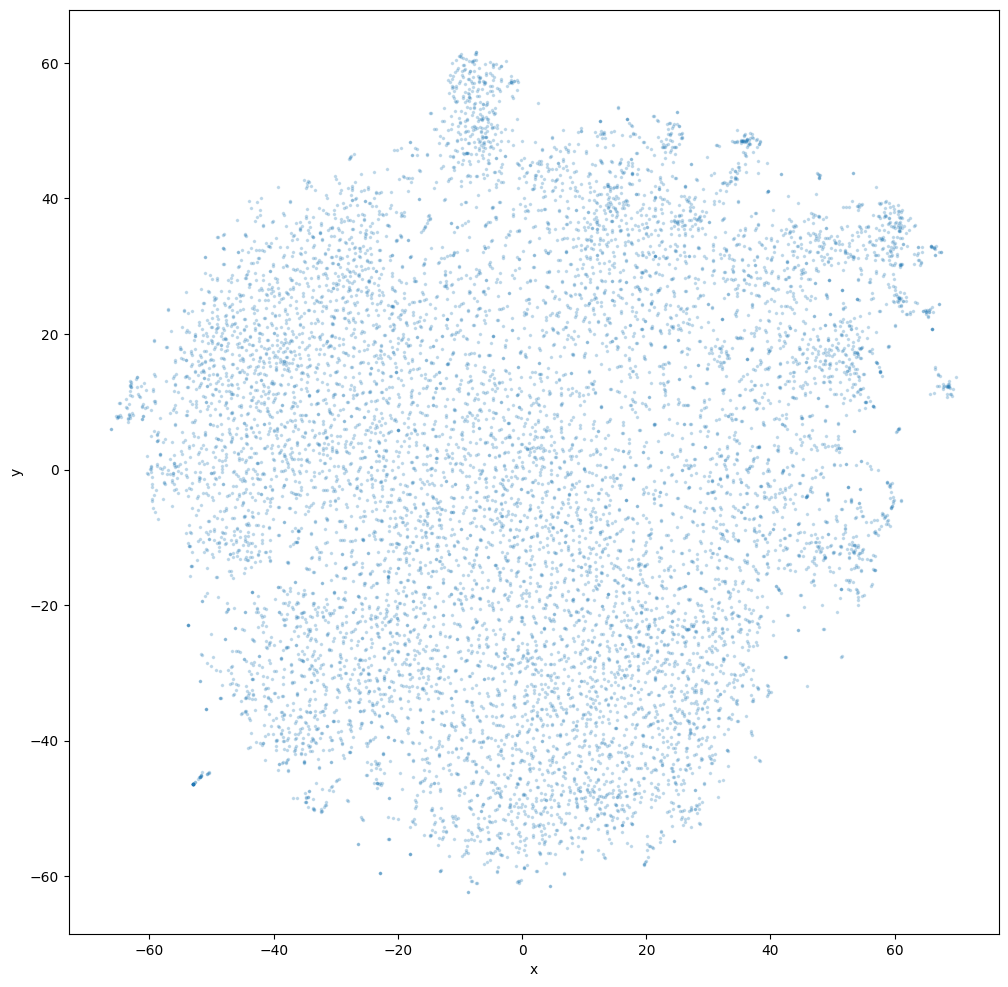

In [138]:
_ = coords_df.plot.scatter('x', 'y', figsize=(12,12), 
                  marker='.', s=10, alpha=0.2)

# 改用bokeh函式庫來畫，互動性更加

In [139]:
output_notebook()

In [140]:
subset_df = coords_df.sample(n=5000)  #先取5000個樣本就好

In [141]:
p = figure(plot_width=800, plot_height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)

In [144]:
show(p)